 modyfied code from book:
 

# Hands-On Markov Models with Python

## By AnkurAnkan, Abinash Panda
### September 2018

 https://www.packtpub.com/product/hands-on-markov-models-with-python/9781788625449

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.filterwarnings("ignore")
# Change plot style to ggplot (for better and more aesthetic visualisation)
plt.style.use('ggplot')


class StockPredictor(object):
    def __init__(self, company, test_size=0.10,
                 n_hidden_states=4, n_latency_days=10,
                 n_steps_frac_change=50, n_steps_frac_high=10,
                 n_steps_frac_low=10):
    

        self.company = company
        self.n_latency_days = n_latency_days

        self.hmm = GaussianHMM(n_components=n_hidden_states) #domyslne 4 stany

        self._split_train_test_data(test_size)

        self._compute_all_possible_outcomes(n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)


    def _split_train_test_data(self, test_size):
        
        self.data = pd.read_csv('{company}.csv'.format(company=self.company),header=0)

        _train_data, test_data = train_test_split(self.data, test_size=test_size, shuffle=False)

        self._train_data = _train_data
        self._test_data = test_data

    @staticmethod
    def _extract_features(data):
        #calculating featers
        
        open_price = np.array(data['open'])
        close_price = np.array(data['close'])
        high_price = np.array(data['high'])
        low_price = np.array(data['low'])

        # Compute the fraction change in close, high and low prices
        # which would be used as a feature
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
        
        return np.column_stack((frac_change, frac_high, frac_low))

    def fit(self):
        # fitting model using calculating featers
        
        
        feature_vector = StockPredictor._extract_features(self._train_data)
        self.temp_feature_vector = feature_vector
        
        self.hmm.fit(feature_vector)

    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        
        # genarating categrical outcomes
        
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)

        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))
        

    def _get_most_probable_outcome(self, day_index):
       
        # choosing most probable output
        
        previous_data_start_index = max(0, day_index - self.n_latency_days) #latency domyslne 10
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index] # tak bylo
       
        previous_data_features = StockPredictor._extract_features(previous_data)
        n = 0
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
           
            n+=1
            outcome_score.append(self.hmm.score(total_data))
       
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]

        return most_probable_outcome

    def predict_close_price(self, day_index):
       
        open_price = self._test_data.iloc[day_index]['open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(day_index)
        return open_price * (1 + predicted_frac_change)

    def predict_close_prices_for_days(self, days, with_plot=False):
        # wywolane bezposrednio
        
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
      
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data['Date'], dtype="datetime64[ms]")
            actual_close_prices = test_data['close']

            fig = plt.figure()

            self.test = actual_close_prices
            self.prediction = predicted_close_prices
            
            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
            #axes.set_title('{company}'.format(company=self.company))
            axes.set_title('S&P')

            fig.autofmt_xdate()

            plt.legend()
            plt.show()

        
        
        return predicted_close_prices

In [3]:
stock_predictor = StockPredictor("SnP")
stock_predictor.fit()


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


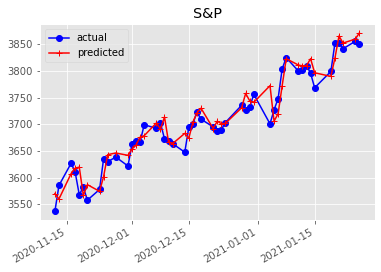

In [5]:
a = stock_predictor.predict_close_prices_for_days(50, with_plot=True)

In [6]:
def hmm_score(test,prediction):
# scores the relative error of prediction 
    np_test = np.array(test)
    np_pred = np.array(prediction)
    score = np.abs((np_test - np_pred)/np_test)
    
    return np.mean(score)



score = hmm_score(stock_predictor.test,stock_predictor.prediction)
print(f"Model relative error is: {100*score:.2f} %")



Model relative error is: 0.47 %
